In [ ]:
# ========================================
# 📚 Imports and Setup
# ========================================
import os, cv2, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch_directml

# ========================================
# ⚙️ Device Setup
# ========================================
device = "privateuseone:0" if torch_directml.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device: {device}")

# ========================================
# 🧩 Paths and Parameters
# ========================================
ROOT_DIR = r"C:\Users\Reuth\anaconda_projects\image_project\photos_for_tags_algo"
IMG_DIR = os.path.join(ROOT_DIR, "images")
MASK_DIR = os.path.join(ROOT_DIR, "masks")

IMG_SIZE = 512
VAL_SPLIT = 0.2
BATCH = 2
RANDOM_SEED = 42


c:\Users\Reuth\anaconda3\envs\dml_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Using device: privateuseone:0


In [4]:
# ========================================
# 📁 Dataset: Wound Segmentation (Auto Pairing)
# ========================================
import os, re, random, glob
from pathlib import Path
from typing import List, Tuple, Dict
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# נתיב מוחלט – כך ש־VS Code ידע בדיוק איפה לחפש
ROOT_DIR = Path(r"C:\Users\Reuth\anaconda_projects\image_project\photos_for_tags_algo")

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

def normalize_stem(stem: str) -> str:
    """מסיר סיומות כמו _MASK/_mask/_MARKED משם הקובץ"""
    return re.sub(r'(?i)_(mask|marked)$', '', stem)

def is_marked(stem: str) -> bool:
    return re.search(r'(?i)_marked$', stem) is not None

def is_mask(stem: str) -> bool:
    return re.search(r'(?i)_mask$', stem) is not None

def scan_pairs(root: Path) -> List[Tuple[Path, Path]]:
    """סריקה רקורסיבית של תמונות ומאסקים תואמים"""
    files = [Path(p) for p in glob.glob(str(root / "**" / "*"), recursive=True)]
    files = [p for p in files if p.is_file() and p.suffix.lower() in IMG_EXTS]

    by_base: Dict[str, Dict[str, Path]] = {}
    for p in files:
        stem = p.stem
        base = normalize_stem(stem)
        if is_marked(stem):
            continue
        entry = by_base.setdefault(base, {})
        if is_mask(stem):
            entry["mask"] = p
        else:
            entry["img"] = p

    pairs = [(rec["img"], rec["mask"]) for rec in by_base.values() if "img" in rec and "mask" in rec]
    return pairs

# ========================================
# 🎯 Dataset Class
# ========================================
IMG_SIZE = 512
VAL_SPLIT = 0.2
BATCH = 2
RANDOM_SEED = 42

class WoundDataset(Dataset):
    def __init__(self, pairs, train=True):
        self.pairs = pairs
        if train:
            self.tf_img = transforms.Compose([
                transforms.Resize((IMG_SIZE, IMG_SIZE)),
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.3),
                transforms.RandomRotation(15),
                transforms.ToTensor()
            ])
        else:
            self.tf_img = transforms.Compose([
                transforms.Resize((IMG_SIZE, IMG_SIZE)),
                transforms.ToTensor()
            ])
        self.tf_mask = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        img = self.tf_img(img)
        mask = self.tf_mask(mask)
        mask = (mask > 0.5).float()

        return img, mask, str(img_path)

# ========================================
# 🔍 Load and Split Dataset
# ========================================
pairs = scan_pairs(ROOT_DIR)
print(f"🧩 Found {len(pairs)} image-mask pairs")

random.seed(RANDOM_SEED)
random.shuffle(pairs)
n_val = max(1, int(len(pairs) * VAL_SPLIT))
train_pairs, val_pairs = pairs[:-n_val], pairs[-n_val:]

train_ds = WoundDataset(train_pairs, train=True)
val_ds = WoundDataset(val_pairs, train=False)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=0)

print(f"Train: {len(train_ds)}  |  Val: {len(val_ds)}")

# ✅ דוגמה ראשונה לבדיקה
# ✅ דוגמה ראשונה לבדיקה
sample_img, sample_mask = random.choice(train_pairs)
print("🖼️ Example pair:")
print("Image:", sample_img)
print("Mask:", sample_mask)



🧩 Found 143 image-mask pairs
Train: 115  |  Val: 28
🖼️ Example pair:
Image: C:\Users\Reuth\anaconda_projects\image_project\photos_for_tags_algo\10 (2)\IMG_1461.JPG
Mask: C:\Users\Reuth\anaconda_projects\image_project\photos_for_tags_algo\10 (2)\IMG_1461_MASK.jpg


In [5]:
# ========================================
# 🧠 Feature Pyramid Network (FPN) + ResNet50 + Attention
# ========================================
class FPNResNet50_Attention(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = smp.FPN(
            encoder_name="resnet50",
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
            activation=None
        )
        # Squeeze-Excitation (Channel Attention)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(1, 1, 1),
            nn.Sigmoid()
        )
        self.dropout = nn.Dropout2d(0.3)

    def forward(self, x):
        x = self.base(x)
        w = self.se(x)
        x = x * w
        x = self.dropout(x)
        return x

model = FPNResNet50_Attention().to(device)
print("✅ FPN + ResNet50 + Attention initialized.")


c:\Users\Reuth\anaconda3\envs\dml_env\lib\site-packages\huggingface_hub\file_download.py:120: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Reuth\.cache\huggingface\hub\models--smp-hub--resnet50.imagenet. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


✅ FPN + ResNet50 + Attention initialized.


In [16]:
# ========================================
# 🧩 FPN + ResNet50 (Deep Edge Refinement)
# ========================================
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2

import torch_directml
device = torch_directml.device()
print(f"✅ Using DirectML device: {device}")


class FPN_ResNet50_Refined(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = smp.FPN(
            encoder_name="resnet50",
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
            activation=None
        )
        # Edge refinement module
        self.refine = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 1, 1)
        )

    def forward(self, x):
        base_out = self.backbone(x)
        refined = self.refine(base_out)
        return base_out + 0.3 * refined  # blending base and refined edges


# ---- Loss Functions (Advanced Edge-Aware) ----
def focal_tversky_loss(logits, targets, alpha=0.7, beta=0.3, gamma=1.4, eps=1e-6):
    p = torch.sigmoid(logits)
    tp = (p * targets).sum(dim=(2,3))
    fp = ((1 - targets) * p).sum(dim=(2,3))
    fn = (targets * (1 - p)).sum(dim=(2,3))
    tversky = (tp + eps) / (tp + alpha*fp + beta*fn + eps)
    return ((1 - tversky) ** gamma).mean()

def weighted_bce_loss(logits, targets, w_neg=3.0, w_pos=1.0, eps=1e-6):
    p = torch.sigmoid(logits)
    weights = torch.where(
        targets > 0.5,
        torch.tensor(w_pos, device=logits.device),
        torch.tensor(w_neg, device=logits.device)
    )
    loss = -weights * (targets * torch.log(p + eps) + (1 - targets) * torch.log(1 - p + eps))
    return loss.mean()

def boundary_loss(logits, targets):
    sobel_x = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], dtype=torch.float32, device=logits.device).unsqueeze(0).unsqueeze(0)
    sobel_y = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], dtype=torch.float32, device=logits.device).unsqueeze(0).unsqueeze(0)
    targets_edge = torch.abs(F.conv2d(targets, sobel_x, padding=1)) + torch.abs(F.conv2d(targets, sobel_y, padding=1))
    preds_edge = torch.abs(F.conv2d(torch.sigmoid(logits), sobel_x, padding=1)) + torch.abs(F.conv2d(torch.sigmoid(logits), sobel_y, padding=1))
    return F.l1_loss(preds_edge, targets_edge)

def color_contrast_loss(imgs, logits):
    """מעודד הפרדת צבע בין הפצע לעור"""
    p = torch.sigmoid(logits)
    pred_mask = (p > 0.5).float()
    lab_imgs = imgs.permute(0,2,3,1).cpu().numpy()
    losses = []
    for i in range(len(lab_imgs)):
        lab = cv2.cvtColor((lab_imgs[i]*255).astype(np.uint8), cv2.COLOR_RGB2LAB)
        wound = lab[pred_mask[i,0].cpu().numpy() > 0.5]
        skin  = lab[pred_mask[i,0].cpu().numpy() <= 0.5]
        if len(wound)==0 or len(skin)==0: continue
        mean_wound, mean_skin = wound.mean(axis=0), skin.mean(axis=0)
        diff = np.linalg.norm(mean_wound - mean_skin)
        losses.append(np.exp(-diff/40))
    return torch.tensor(losses, device=logits.device).mean() if losses else 0.0

def loss_fn(imgs, logits, targets):
    """שקלול חכם — דגש חזק יותר על גבולות"""
    return (
        0.35 * focal_tversky_loss(logits, targets)
        + 0.25 * weighted_bce_loss(logits, targets)
        + 0.25 * boundary_loss(logits, targets)
        + 0.15 * color_contrast_loss(imgs, logits)
    )

@torch.no_grad()
def iou_score(logits, y, thr=0.5, eps=1e-6):
    p = (torch.sigmoid(logits) > thr).float()
    inter = (p * y).sum(dim=(2,3))
    union = (p + y - p*y).sum(dim=(2,3)) + eps
    return (inter / union).mean().item()


✅ Using DirectML device: privateuseone:0


[Epoch 01/50] train_loss=0.1773 | val_loss=0.1118 | IoU=0.9699 | Prec=0.9866 | Recall=0.9830
✅ Saved new best model to fpn_resnet50_refined_best.pt


[Epoch 02/50] train_loss=0.1715 | val_loss=0.1000 | IoU=0.9712 | Prec=0.9803 | Recall=0.9907
✅ Saved new best model to fpn_resnet50_refined_best.pt


[Epoch 03/50] train_loss=0.1678 | val_loss=0.1149 | IoU=0.9646 | Prec=0.9900 | Recall=0.9743
⚠️ No improvement (1/10)


[Epoch 04/50] train_loss=0.1926 | val_loss=0.1093 | IoU=0.9692 | Prec=0.9863 | Recall=0.9826
⚠️ No improvement (2/10)


[Epoch 05/50] train_loss=0.1711 | val_loss=0.1061 | IoU=0.9715 | Prec=0.9863 | Recall=0.9849
⚠️ No improvement (3/10)


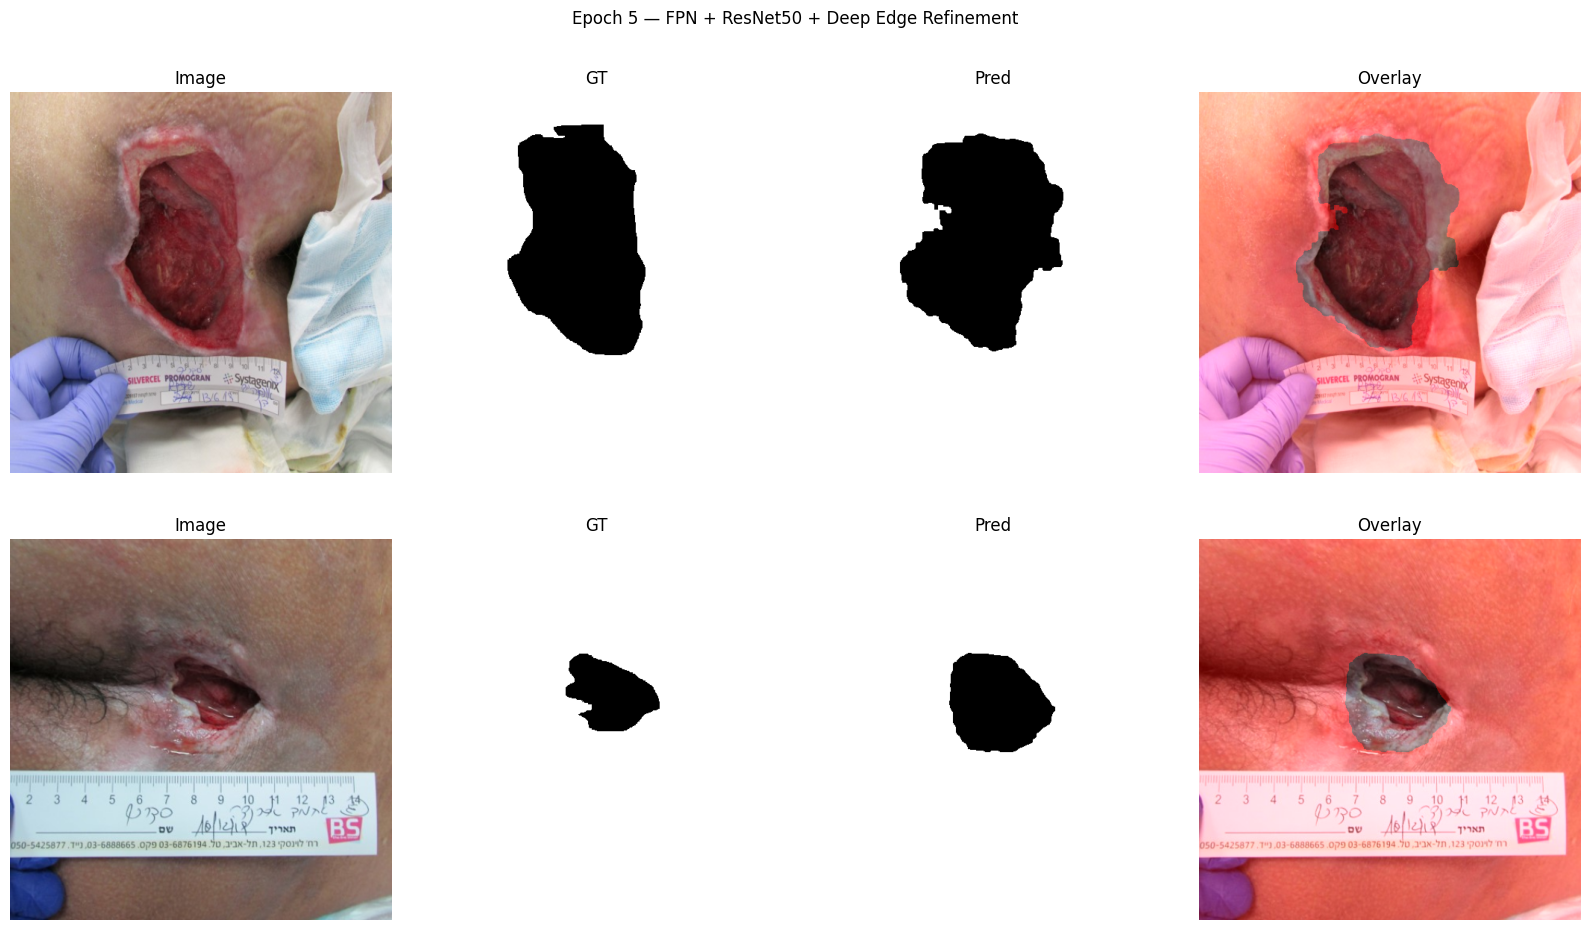

[Epoch 06/50] train_loss=0.1654 | val_loss=0.0981 | IoU=0.9710 | Prec=0.9781 | Recall=0.9927
✅ Saved new best model to fpn_resnet50_refined_best.pt


[Epoch 07/50] train_loss=0.1764 | val_loss=0.1009 | IoU=0.9692 | Prec=0.9875 | Recall=0.9814
⚠️ No improvement (1/10)


[Epoch 08/50] train_loss=0.1816 | val_loss=0.1066 | IoU=0.9686 | Prec=0.9921 | Recall=0.9762
⚠️ No improvement (2/10)


[Epoch 09/50] train_loss=0.1746 | val_loss=0.1092 | IoU=0.9635 | Prec=0.9908 | Recall=0.9723
⚠️ No improvement (3/10)


[Epoch 10/50] train_loss=0.1575 | val_loss=0.0941 | IoU=0.9714 | Prec=0.9864 | Recall=0.9847
✅ Saved new best model to fpn_resnet50_refined_best.pt


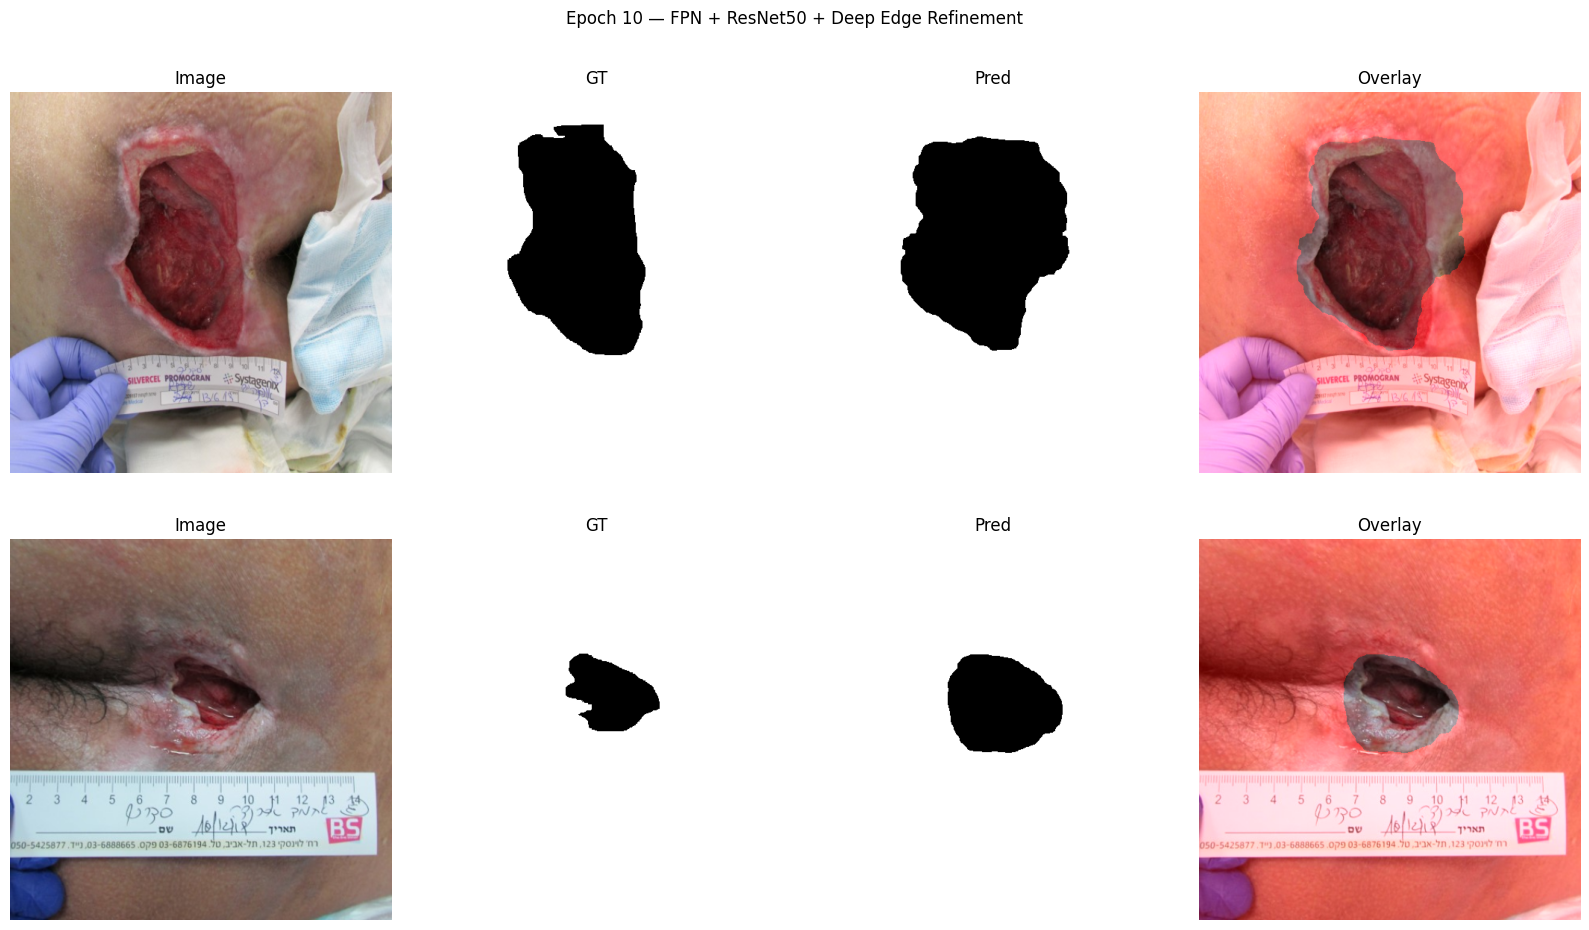

[Epoch 11/50] train_loss=0.1706 | val_loss=0.0928 | IoU=0.9696 | Prec=0.9858 | Recall=0.9835
✅ Saved new best model to fpn_resnet50_refined_best.pt


[Epoch 12/50] train_loss=0.1663 | val_loss=0.0911 | IoU=0.9727 | Prec=0.9829 | Recall=0.9896
✅ Saved new best model to fpn_resnet50_refined_best.pt


[Epoch 13/50] train_loss=0.1810 | val_loss=0.1025 | IoU=0.9646 | Prec=0.9871 | Recall=0.9770
⚠️ No improvement (1/10)


[Epoch 14/50] train_loss=0.1603 | val_loss=0.1045 | IoU=0.9668 | Prec=0.9882 | Recall=0.9781
⚠️ No improvement (2/10)


[Epoch 15/50] train_loss=0.1624 | val_loss=0.0984 | IoU=0.9683 | Prec=0.9834 | Recall=0.9845
⚠️ No improvement (3/10)


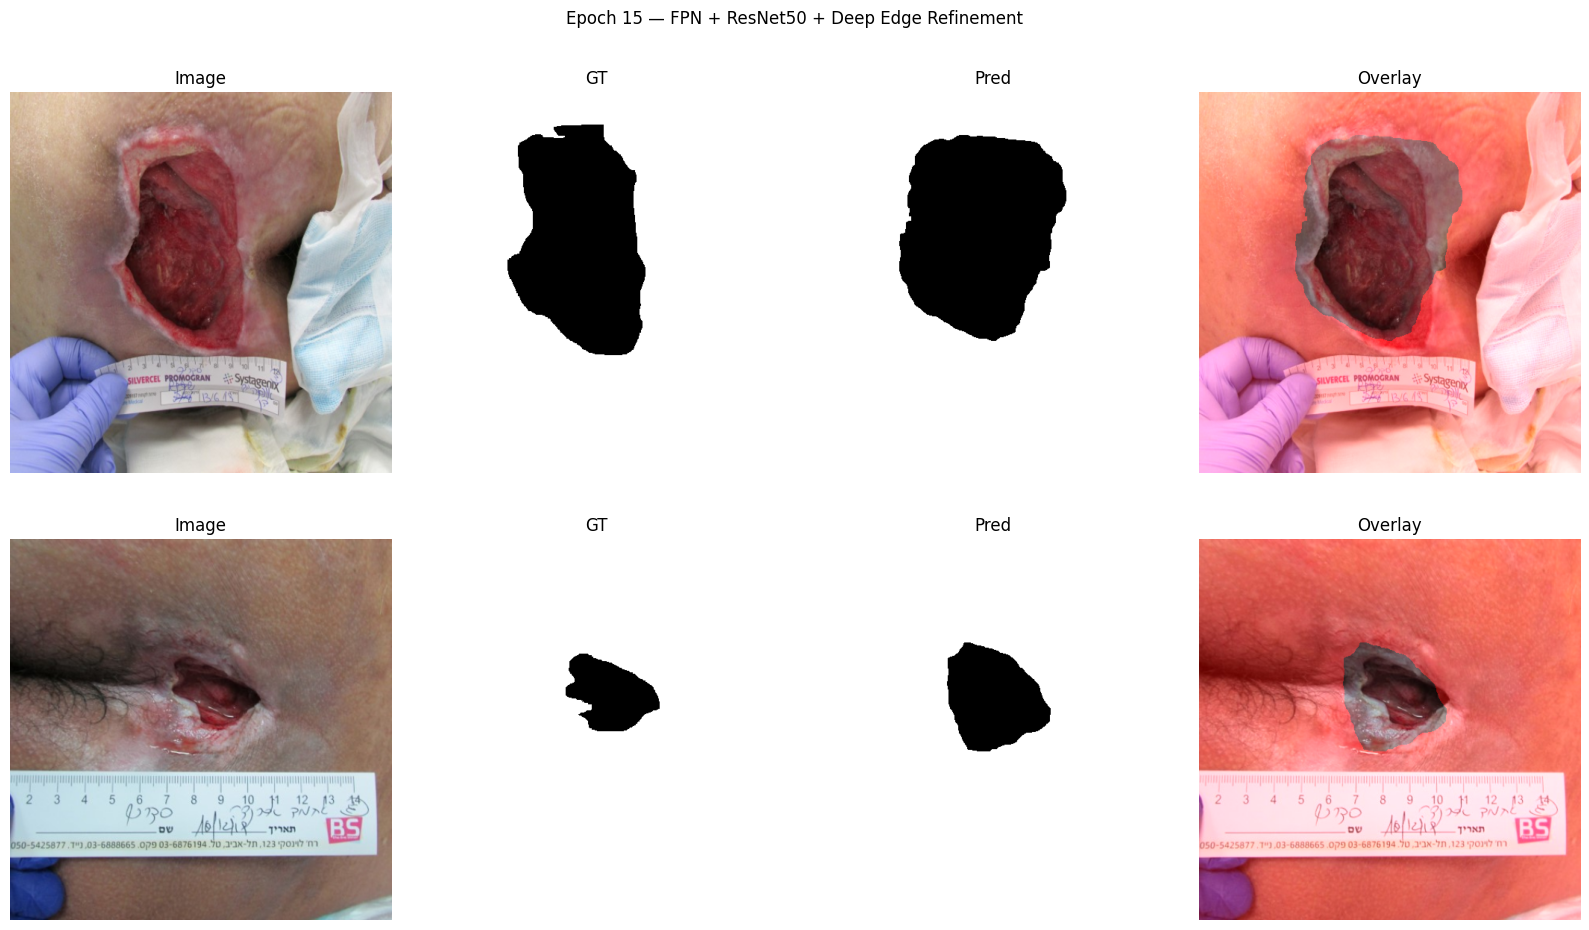

[Epoch 16/50] train_loss=0.1545 | val_loss=0.1045 | IoU=0.9593 | Prec=0.9902 | Recall=0.9687
⚠️ No improvement (4/10)


[Epoch 17/50] train_loss=0.1611 | val_loss=0.0989 | IoU=0.9701 | Prec=0.9871 | Recall=0.9826
⚠️ No improvement (5/10)


[Epoch 18/50] train_loss=0.1734 | val_loss=0.1040 | IoU=0.9671 | Prec=0.9833 | Recall=0.9832
⚠️ No improvement (6/10)


[Epoch 19/50] train_loss=0.1567 | val_loss=0.1050 | IoU=0.9659 | Prec=0.9882 | Recall=0.9772
⚠️ No improvement (7/10)


[Epoch 20/50] train_loss=0.1643 | val_loss=0.0966 | IoU=0.9685 | Prec=0.9790 | Recall=0.9890
⚠️ No improvement (8/10)


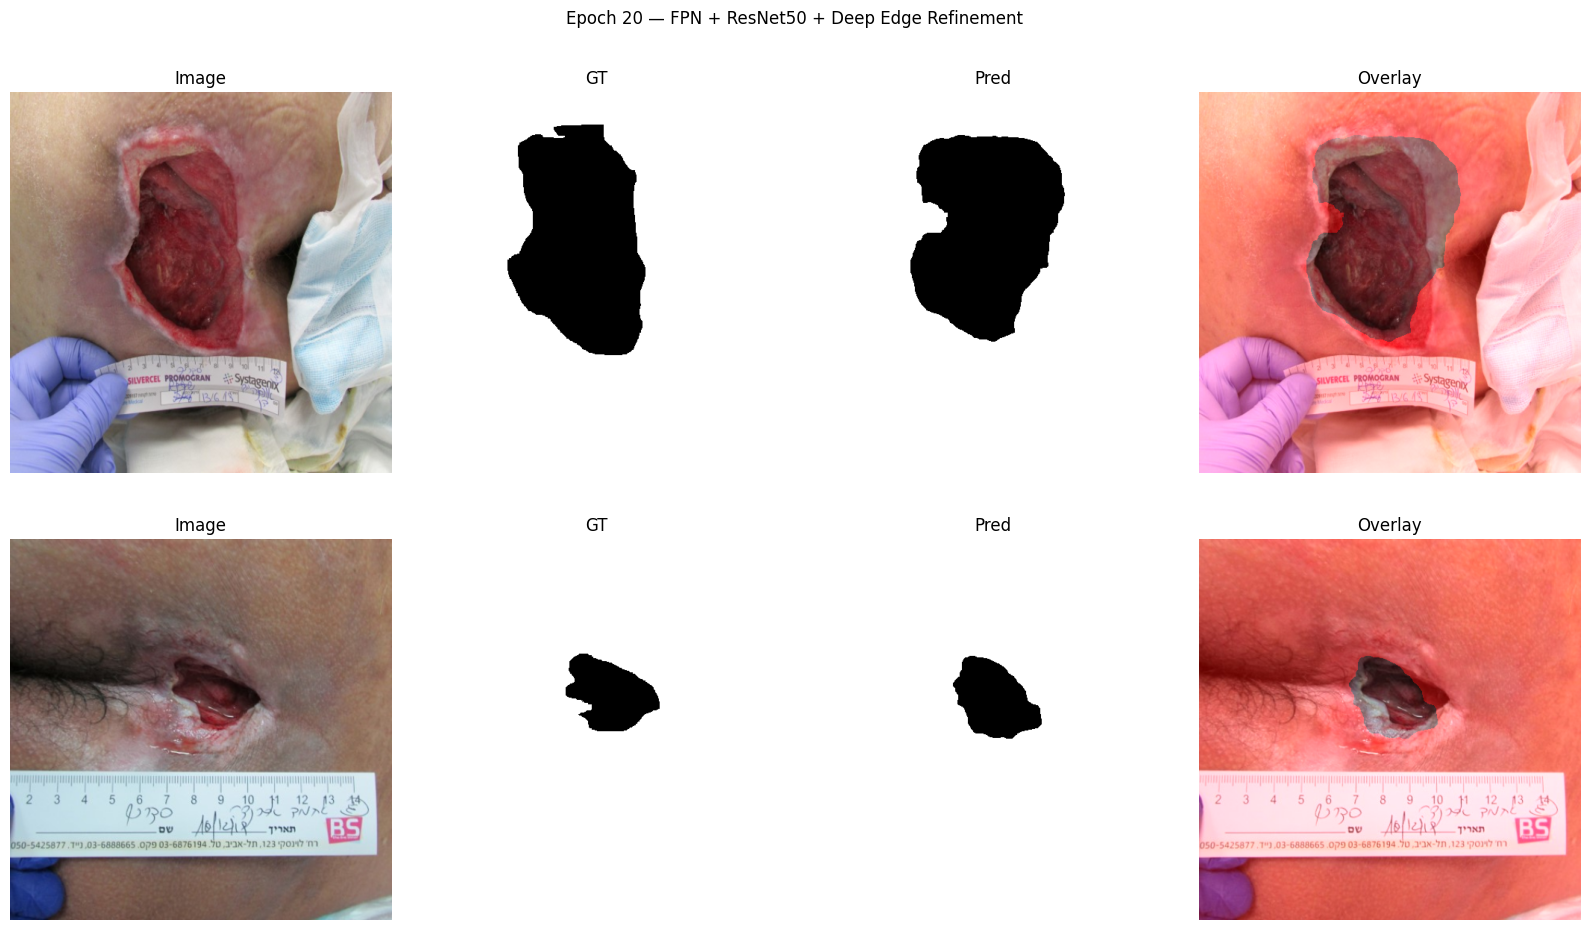

[Epoch 21/50] train_loss=0.1623 | val_loss=0.1002 | IoU=0.9696 | Prec=0.9841 | Recall=0.9851
⚠️ No improvement (9/10)


[Epoch 22/50] train_loss=0.1750 | val_loss=0.0986 | IoU=0.9682 | Prec=0.9869 | Recall=0.9809
⚠️ No improvement (10/10)
⏹ Early stopping.


In [17]:
# ========================================
# 🔁 Training Loop (3-image visualization + metrics)
# ========================================
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)

EPOCHS = 50
PATIENCE = 10
best_val = float('inf')
patience_counter = 0
save_path = "fpn_resnet50_refined_best.pt"

@torch.no_grad()
def precision_recall(logits, y, thr=0.5, eps=1e-6):
    p = (torch.sigmoid(logits) > thr).float()
    tp = (p * y).sum(dim=(2,3))
    fp = (p * (1 - y)).sum(dim=(2,3))
    fn = ((1 - p) * y).sum(dim=(2,3))
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    return precision.mean().item(), recall.mean().item()

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0.0
    for x, y, _ in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = loss_fn(x, logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    train_loss = total_loss / len(train_ds)

    # --- Validation ---
    model.eval()
    val_loss, val_iou, val_precision, val_recall = 0.0, 0.0, 0.0, 0.0
    with torch.no_grad():
        for x, y, _ in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            val_loss += loss_fn(x, logits, y).item() * x.size(0)
            val_iou += iou_score(logits, y) * x.size(0)
            p, r = precision_recall(logits, y)
            val_precision += p * x.size(0)
            val_recall += r * x.size(0)
    val_loss /= len(val_ds)
    val_iou /= len(val_ds)
    val_precision /= len(val_ds)
    val_recall /= len(val_ds)
    scheduler.step(val_loss)

    print(f"[Epoch {epoch:02d}/{EPOCHS}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | IoU={val_iou:.4f} | Prec={val_precision:.4f} | Recall={val_recall:.4f}")

    # --- Save best ---
    if val_loss < best_val:
        best_val = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), save_path)
        print(f"✅ Saved new best model to {save_path}")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement ({patience_counter}/{PATIENCE})")
        if patience_counter >= PATIENCE:
            print("⏹ Early stopping.")
            break

    # --- Visualization every 5 epochs ---
    if epoch % 5 == 0:
        model.eval()
        imgs, masks, _ = next(iter(val_loader))
        imgs, masks = imgs.to(device), masks.to(device)
        preds = torch.sigmoid(model(imgs))
        num_samples = min(3, len(imgs))
        fig, axes = plt.subplots(num_samples, 4, figsize=(16, 5*num_samples))

        for i in range(num_samples):
            pred = preds[i].detach().cpu().squeeze().numpy()
            pred = (pred > 0.5).astype(np.uint8)
            kernel = np.ones((5,5), np.uint8)
            pred = cv2.morphologyEx(pred, cv2.MORPH_CLOSE, kernel)
            pred = cv2.morphologyEx(pred, cv2.MORPH_OPEN, kernel)

            overlay = imgs[i].cpu().permute(1,2,0).numpy().copy()
            overlay = (overlay * 255).astype(np.uint8)
            overlay_mask = np.stack([pred*255, np.zeros_like(pred), np.zeros_like(pred)], axis=2)
            overlay = cv2.addWeighted(overlay, 1.0, overlay_mask, 0.4, 0)

            axes[i,0].imshow(imgs[i].cpu().permute(1,2,0)); axes[i,0].set_title("Image"); axes[i,0].axis("off")
            axes[i,1].imshow(masks[i].cpu().squeeze(), cmap="gray"); axes[i,1].set_title("GT"); axes[i,1].axis("off")
            axes[i,2].imshow(pred, cmap="gray"); axes[i,2].set_title("Pred"); axes[i,2].axis("off")
            axes[i,3].imshow(overlay); axes[i,3].set_title("Overlay"); axes[i,3].axis("off")

        plt.suptitle(f"Epoch {epoch} — FPN + ResNet50 + Deep Edge Refinement")
        plt.tight_layout()
        plt.show()


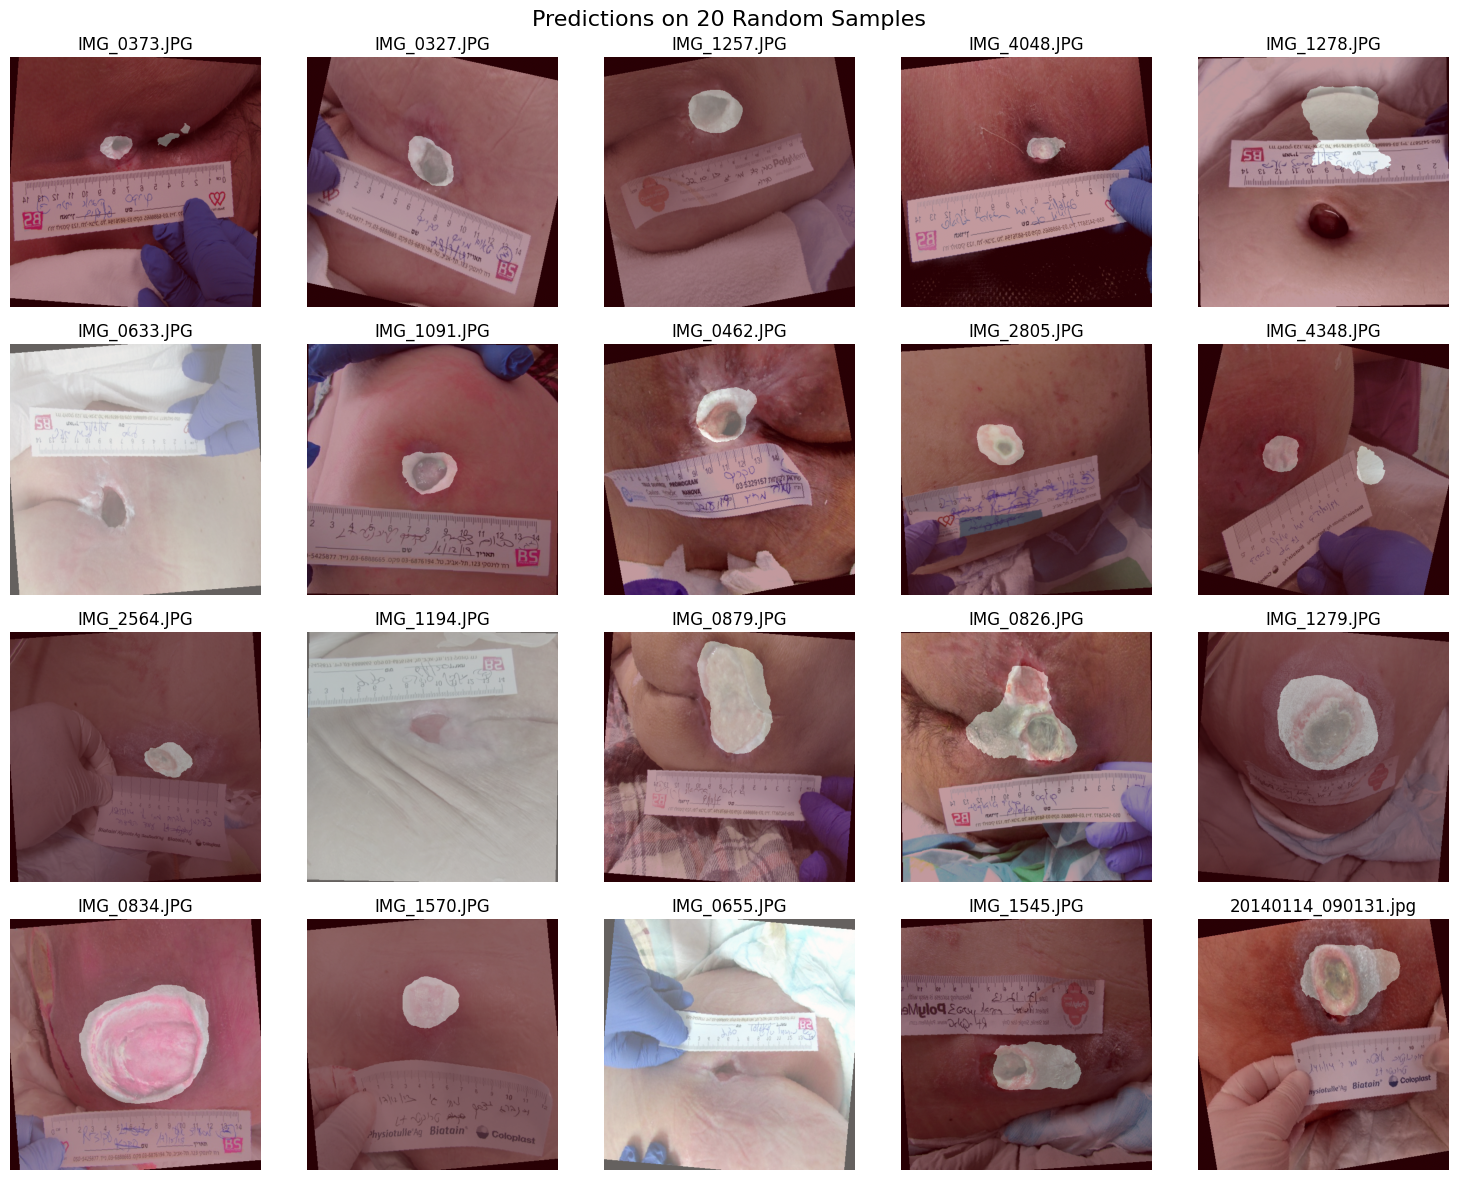

In [18]:
import random
import matplotlib.pyplot as plt

# ✅ הגדרה: הצגת N תמונות רנדומליות מה-dataset (train או val)
def show_random_predictions(model, dataset, n=20, device='cpu', thr=0.5):
    model.eval()
    indices = random.sample(range(len(dataset)), k=min(n, len(dataset)))
    n_rows = (n + 4) // 5  # כל שורה תציג 5 תמונות
    fig, axes = plt.subplots(n_rows, 5, figsize=(15, 3 * n_rows))

    if n_rows == 1:
        axes = np.expand_dims(axes, 0)

    for i, idx in enumerate(indices):
        img, mask, path = dataset[idx]
        img_in = img.unsqueeze(0).to(device)

        with torch.no_grad():
            pred = torch.sigmoid(model(img_in)).squeeze().cpu().numpy()

        pred_bin = (pred > thr).astype(float)
        img_np = img.permute(1,2,0).numpy()
        mask_np = mask.squeeze().numpy()

        ax = axes[i // 5, i % 5]
        ax.imshow(img_np)
        ax.imshow(pred_bin, cmap="Reds", alpha=0.4)
        ax.set_title(f"{os.path.basename(path)}")
        ax.axis("off")

    plt.suptitle(f"Predictions on {n} Random Samples", fontsize=16)
    plt.tight_layout()
    plt.show()

# ✅ קריאה לדוגמה – מתוך קבוצת האימון:
show_random_predictions(model, train_ds, n=20, device=device)

# או אם תרצה דווקא מהוולידציה:
# show_random_predictions(model, val_ds, n=20, device=device)


✅ Using DirectML device: privateuseone:0


C:\Users\Reuth\AppData\Local\Temp\ipykernel_10656\704107578.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


✅ Loaded model weights successfully from: fpn_resnet50_refined_best.pt
📁 Results will be saved under: c:\Users\Reuth\VS_PROJECTS\results_refined_model
🔍 Found 888 test images.


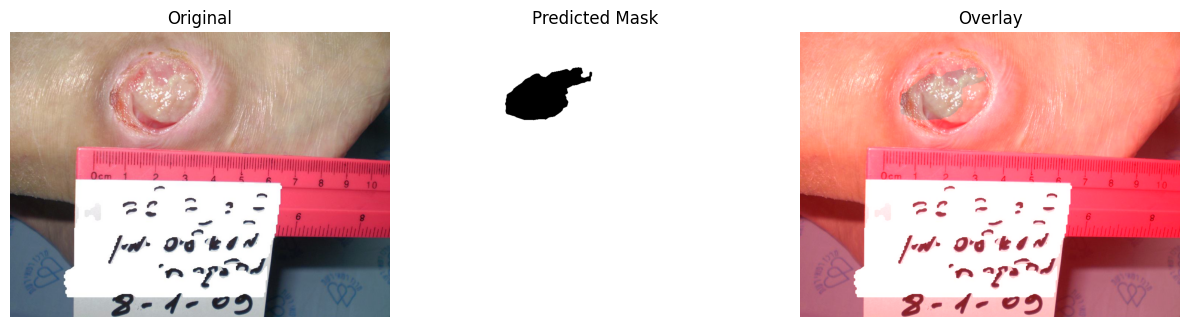

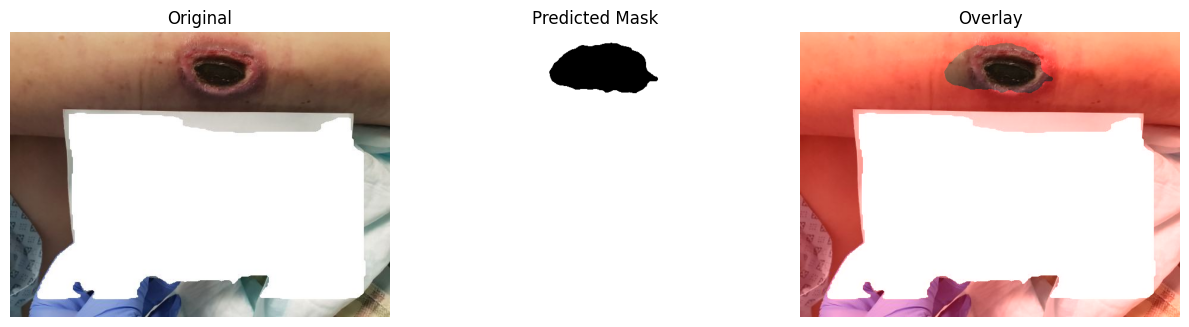

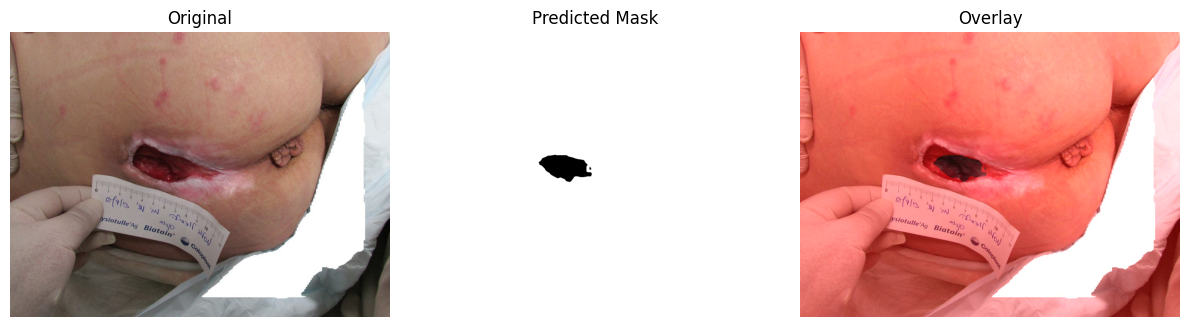

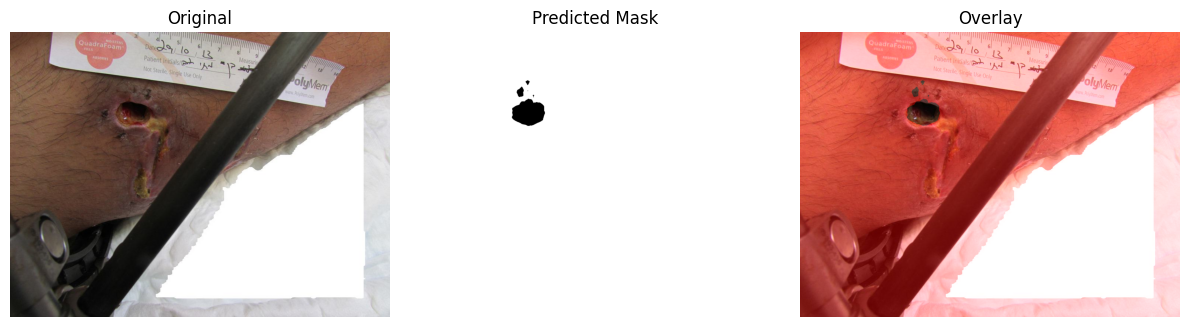

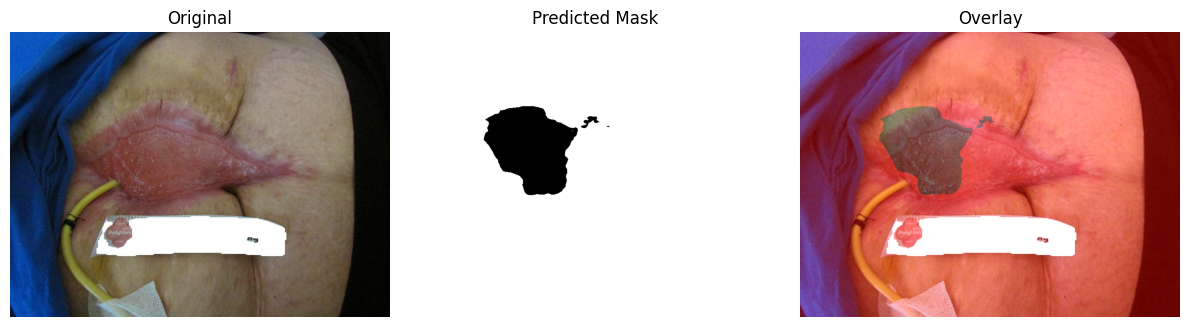

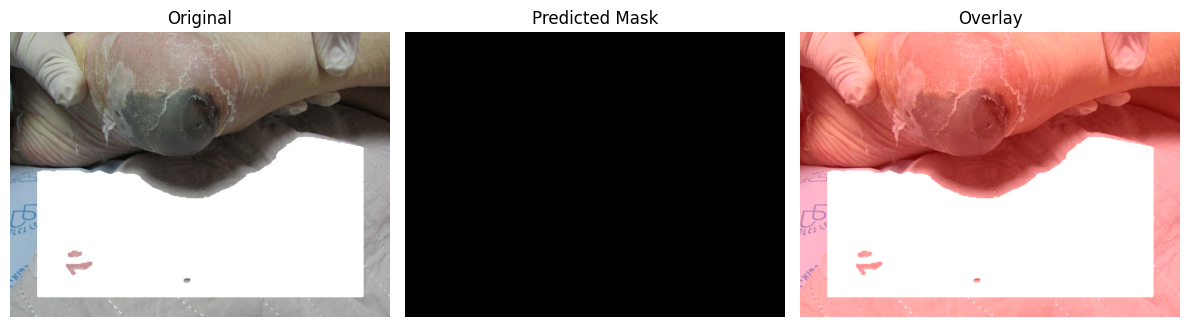

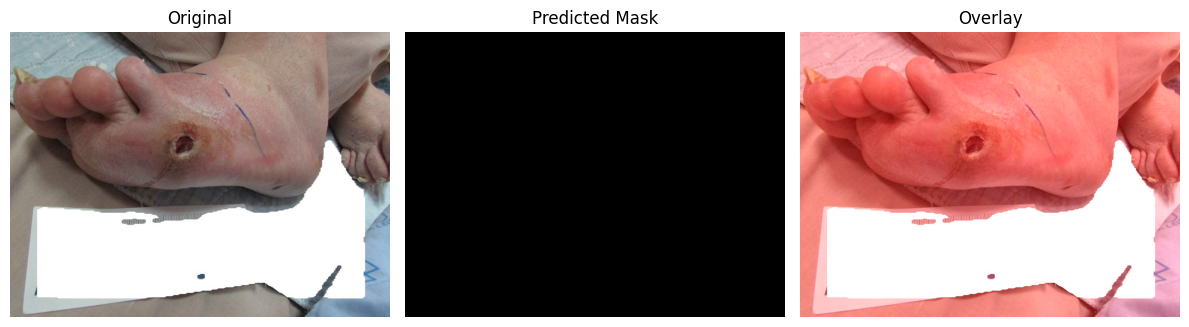

✅ Done! All refined predictions saved under: c:\Users\Reuth\VS_PROJECTS\results_refined_model


In [21]:
# ========================================
# 🧠 Predict Masks using FPN+ResNet50 Refined (Edge-Aware)
# ========================================
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from pathlib import Path
import segmentation_models_pytorch as smp
import torch_directml

# =============================
# ⚙️ הגדרת התקן
# =============================
device = torch_directml.device()
print(f"✅ Using DirectML device: {device}")

# =============================
# 🧩 הגדרת המודל הבסיסי בדיוק כפי שאומַן
# =============================
class FPN_ResNet50_Base(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.base = smp.FPN(
            encoder_name="resnet50",
            encoder_weights="imagenet",  # כמו באימון
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, x):
        return self.base(x)

# =============================
# ✨ מעטפת שיפור קצוות (Refinement)
# =============================
class RefinedModel(torch.nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base = base_model
        self.refine = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, 3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(16, 16, 3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(16, 1, 1)
        )

    def forward(self, x):
        base_out = self.base(x)
        refine_out = self.refine(base_out)
        return base_out + 0.3 * refine_out

# =============================
# 📦 טעינת משקולות המודל
# =============================
model_path = "fpn_resnet50_refined_best.pt"

# טוענים את המודל המקורי שאומַן
base_model = FPN_ResNet50_Base().to(device)
state_dict = torch.load(model_path, map_location=device)
base_model.load_state_dict(state_dict, strict=False)

# עוטפים אותו בשכבת ה-refinement
model = RefinedModel(base_model).to(device)
model.eval()

print(f"✅ Loaded model weights successfully from: {model_path}")

# =============================
# 🧩 טרנספורם בסיסי
# =============================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512)),
])

# =============================
# 📂 תיקיות קלט ופלט
# =============================
test_dir = Path(r"C:\Users\Reuth\anaconda_projects\image_project\copy_only\masks_2\1. Original Wound Photos - from EHR\with_masks")

# תיקייה לשמירת תוצאות בתוך הפרויקט
project_root = Path.cwd()
results_dir = project_root / "results_refined_model"
results_dir.mkdir(exist_ok=True, parents=True)
print(f"📁 Results will be saved under: {results_dir}")

# טעינת רשימת תמונות
image_paths = [p for p in test_dir.glob("*.*") if p.suffix.lower() in {".jpg", ".jpeg", ".png"}]
print(f"🔍 Found {len(image_paths)} test images.")

# =============================
# 🔮 פונקציית חיזוי
# =============================
@torch.no_grad()
def predict_mask(image_path, thr=0.45):
    """הרצת המודל על תמונה בודדת והחזרת מסכה + overlay"""
    img_bgr = cv2.imread(str(image_path))
    if img_bgr is None:
        raise FileNotFoundError(f"❌ Failed to read: {image_path}")

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    orig_h, orig_w = img_rgb.shape[:2]

    tensor = transform(img_rgb).unsqueeze(0).to(device)
    pred = torch.sigmoid(model(tensor)).cpu().squeeze().numpy()
    pred = cv2.resize(pred, (orig_w, orig_h))
    pred_bin = (pred > thr).astype(np.uint8) * 255

    return img_rgb, pred_bin

# =============================
# 🚀 הרצה על עד 100 תמונות ושמירה
# =============================
for i, img_path in enumerate(image_paths[:100]):
    img_rgb, mask_pred = predict_mask(img_path)

    sub_dir = results_dir / img_path.stem
    sub_dir.mkdir(exist_ok=True, parents=True)

    img_save_path = sub_dir / f"{img_path.stem}_IMG.png"
    mask_save_path = sub_dir / f"{img_path.stem}_MASK.png"
    overlay_save_path = sub_dir / f"{img_path.stem}_OVERLAY.png"

    # שמירת התמונה, המסכה, והאוברליי
    cv2.imwrite(str(img_save_path), cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
    cv2.imwrite(str(mask_save_path), mask_pred)

    overlay = img_rgb.copy()
    red_mask = np.stack([mask_pred, np.zeros_like(mask_pred), np.zeros_like(mask_pred)], axis=2)
    overlay = cv2.addWeighted(overlay, 1.0, red_mask, 0.4, 0)
    cv2.imwrite(str(overlay_save_path), cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

    # הדמיה כל 15 תמונות
    if i % 15 == 0:
        plt.figure(figsize=(12,6))
        plt.subplot(1,3,1); plt.imshow(img_rgb); plt.title("Original"); plt.axis("off")
        plt.subplot(1,3,2); plt.imshow(mask_pred, cmap="gray"); plt.title("Predicted Mask"); plt.axis("off")
        plt.subplot(1,3,3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
        plt.tight_layout()
        plt.show()

print(f"✅ Done! All refined predictions saved under: {results_dir}")
